# Craindo modelo

In [ ]:
import pandas as pd

SEED = 101

dados_para_modelo = pd.read_csv('dados_para_modelo.csv', sep = ';')
dados_para_modelo = dados_para_modelo.sample(n= 100000, random_state = SEED)
dados_para_modelo.reset_index(inplace = True, drop = True)

In [ ]:
from surprise import KNNBasic
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split as train_test_split_surprise

In [ ]:
leitor_dados = Reader(line_format = 'item user rating')

dados = Dataset.load_from_df(dados_para_modelo,
                             reader = leitor_dados)

dados_treino, dados_teste = train_test_split_surprise(dados,
                                                      test_size = 0.3,
                                                      random_state=SEED)

#### Modelo KNNBasic

In [ ]:
modelo_recomendacao_livro = KNNBasic(k = 10,
                sim_options = {'user_based': False})

In [ ]:
modelo_recomendacao_livro.fit(dados_treino)

Computing the msd similarity matrix...
Done computing similarity matrix.


#### Gerando previsões

In [ ]:
previsoes = modelo_recomendacao_livro.test(dados_teste)

#### Raiz quadrada do erro quadrático médio (RMSE)

In [ ]:
accuracy.rmse(previsoes)

RMSE: 3.2135


3.21353519136128

#### Gerando recomendações

In [ ]:
modelo_recomendacao_livro.get_neighbors(200, k = 10) #index da linha

[542, 1979, 2345, 2531, 2584, 6167, 7206, 10615, 14895, 20550]

In [ ]:
dados_para_modelo.iloc[modelo_recomendacao_livro.get_neighbors(200, k = 10)]

,titulo_do_livro,usuarioid,avaliacao_livro
542,Missing Susan: An Elizabeth Macpherson Mystery,271438,7.0
1979,In the Blink of an Eye Revised 2nd Edition,56856,9.0
2345,Caroline'S Child (Heart Of Texas) (Power Trilogy),66067,8.0
2531,Golf courses of the PGA Tour,248419,7.0
2584,Tao Te Ching (Penguin Classics),68846,10.0
6167,Johnny Tremain (Yearling Newbery),93141,5.0
7206,Le Temple Du Soleil / Prisoners of the Sun (Ti...,196148,9.0
10615,Letters from Jenny,128942,7.0
14895,Fortune's Hand,277466,7.0
20550,Civil Rights Actions: Enforcing the Constituti...,76499,10.0


In [ ]:
dados_para_modelo.iloc[[200]]

,titulo_do_livro,usuarioid,avaliacao_livro
200,Suddenly,177375,9.0


### Função para recomendar com base no id do usuário

In [ ]:
def recomendar(referencia: int, quantidade: int):
    user_ref = dados_para_modelo.query('usuarioid == @referencia').index[0]
    lista_livros = modelo_recomendacao_livro.get_neighbors(user_ref, k = quantidade)
    lista_livros = dados_para_modelo.iloc[lista_livros]
    lista_livros = lista_livros[['titulo_do_livro', 'avaliacao_livro']].set_index("titulo_do_livro")
    return lista_livros

In [ ]:
recomendar(68846, 10)

,avaliacao_livro
titulo_do_livro,
Suddenly,9.0
The Scar,10.0
Harry Potter and the Order of the Phoenix (Book 5),10.0
The Firm,9.0
Mondlaub.,5.0
"Renegade (Palmer, Diana)",7.0
Texasville,8.0
Kiss Mommy Goodbye,8.0
Unleashing the Ideavirus,7.0


###  Observando qual livro é mais recomendado (para os primeiros 10 usuários)

In [ ]:
usuarios = dados_para_modelo.usuarioid.head(10)
usuarios

0    126196
1    156462
2    217818
3    150424
4     36741
5     68383
6     16795
7    114368
8    249732
9    179734
Name: usuarioid, dtype: int64

In [ ]:
recomendacoes = []

for usuario in usuarios:
    recomendacao_modelo = recomendar(usuario, 10)
    for livro in recomendacao_modelo.index:
        recomendacoes.append(livro)

In [ ]:
len(recomendacoes)

100

In [ ]:
from collections import Counter

Counter(recomendacoes)

Counter({'Hanging by a Thread (Ferris, Monica. Needlecraft Mysteries.)': 1,
         'Best Plants for Your Garden': 1,
         'The Gift': 1,
         "Tintin Au Pays de L'Or Noir / Land of Black Gold (Tintin)": 1,
         'One Wish': 1,
         "Discover and Explore Toronto's Waterfront: A Walker's Jogger's Cyclist's Boater's Guide to Toronto's Lakeside Sites and History (The Toronto Sketches Series)": 1,
         'DREADFUL FUTURE OF THE BLOSSOM CULP, THE': 1,
         'Das MÃ?Â¤dchen. (Schwarzer Umschlag).': 1,
         'Acid Row': 1,
         'The Green Mile': 1,
         'Dealing With Dragons (Enchanted Forest Chronicles (Paperback))': 1,
         'The Calvin and Hobbes Tenth Anniversary Book': 1,
         'The Drawing of the Three (The Dark Tower, Book 2)': 1,
         'Your Oasis on Flame Lake': 1,
         'Narrative of the Life of Frederick Douglass an American Slave (Bedford Books in American History)': 1,
         "Conquerors' Pride (The Conquerors Saga, Book One)": 1,
   

In [ ]:
Counter(recomendacoes).values()

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 2, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1])

In [ ]:
dicionario_livros_aparicoes = dict(Counter(recomendacoes))

In [ ]:
livro_recomandado_mais_de_1_vez = dict()

for livro in dicionario_livros_aparicoes:
    if dicionario_livros_aparicoes[livro] > 1:
        livro_recomandado_mais_de_1_vez[livro] = dicionario_livros_aparicoes[livro]

In [ ]:
livro_recomandado_mais_de_1_vez

{'Quentins': 5,
 'The Secret Life of Bees': 5,
 'Murder in the White House': 5,
 'Treat Her Right (Men To The Rescue) (Harlequin Temptation, No. 852)': 4,
 'The Norton Introduction to Literature': 4,
 'Listen Up: How to Improve Relationships, Reduce Stress, and Be More Productive by Using the Power of Listening': 4,
 'In Too Deep': 2,
 "Gabriel's Well": 3,
 'Bad Heir Day': 2,
 'One for the Money (A Stephanie Plum Novel)': 2,
 "What to Expect When You're Expecting (Revised Edition)": 3}

#### Gráfico

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
livros_recomandado_ordem = []

for livro in sorted(livro_recomandado_mais_de_1_vez, key = livro_recomandado_mais_de_1_vez.get, reverse = True):
    livros_recomandado_ordem.append(livro)

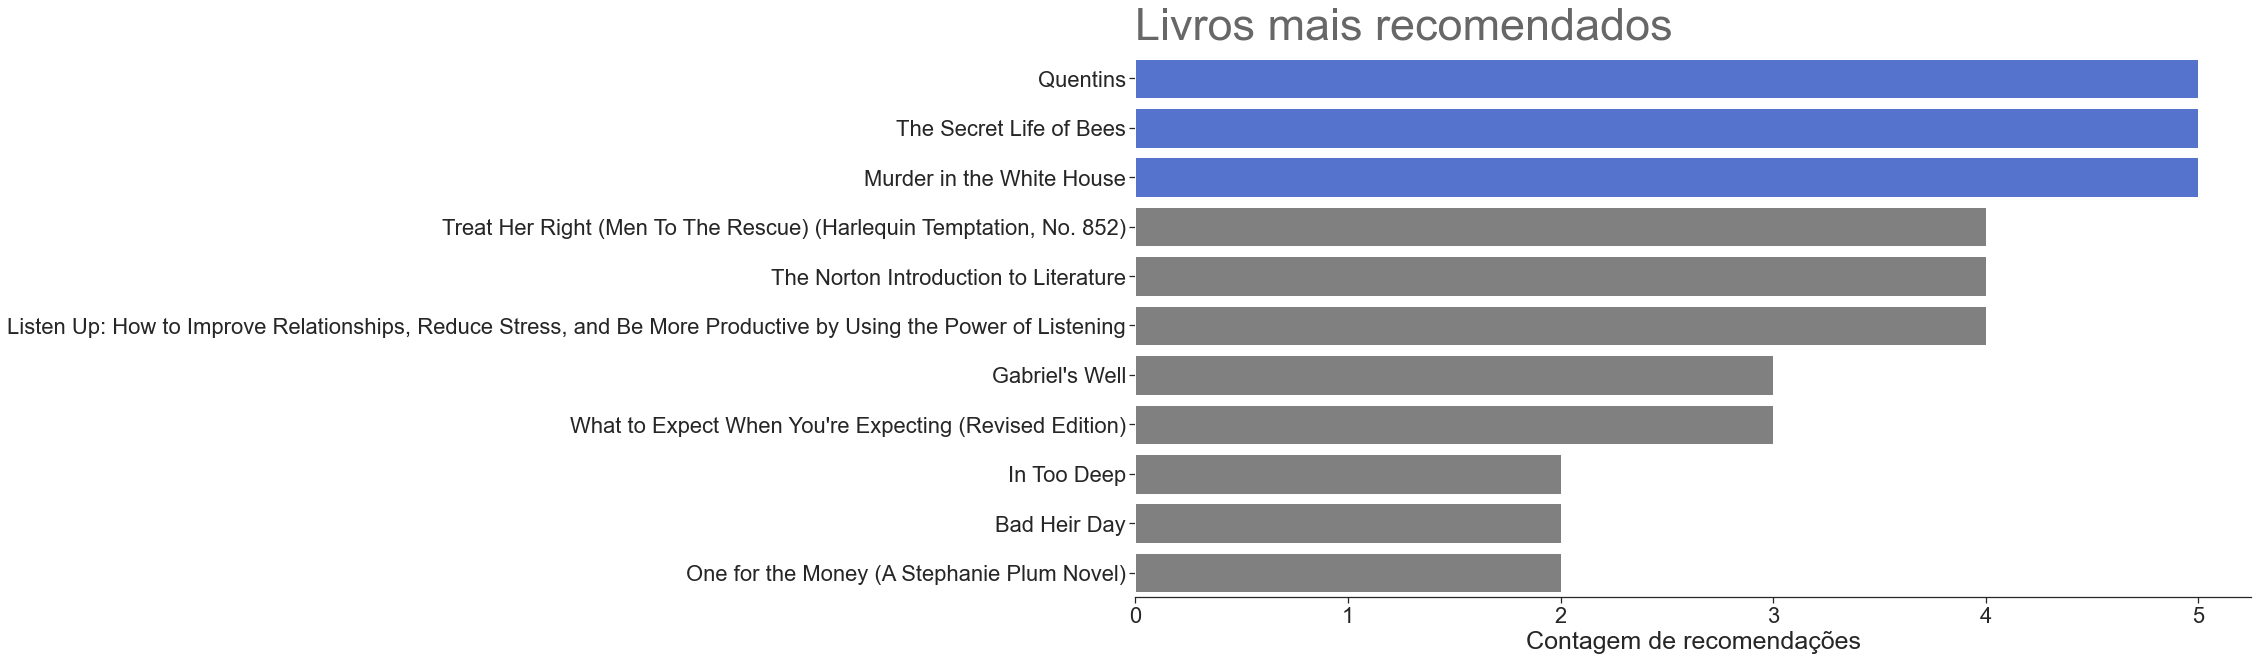

In [ ]:
eixo_x = list(livro_recomandado_mais_de_1_vez.values())
eixo_y = list(livro_recomandado_mais_de_1_vez.keys())

sns.set(rc={'figure.figsize':(20,10), 'font.size' : 15}, font_scale = 2)
sns.set_style("ticks")

cores = ['royalblue', 'royalblue', 'royalblue', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']

grafico_notas = sns.barplot(x = eixo_x, y = eixo_y, palette = cores, order = livros_recomandado_ordem)

grafico_notas.set_xlabel('Contagem de recomendações', fontsize = 25)
grafico_notas.set_title("Livros mais recomendados", fontsize = 45, pad =15, loc = 'left', alpha = 0.7)

sns.despine(left = True)
plt.show()